In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from Scripts.data_loader import DataLoader

%load_ext autoreload
%autoreload 2
%matplotlib inline

<img src=https://i.stack.imgur.com/gyuw4.png>

In [2]:
def get_color_pixels(image, color):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    if color == "black":
        return cv2.inRange(image_hsv, (0, 0, 0), (180, 255, 45))

    elif color == "green":
        return cv2.inRange(image_hsv, (40, 50, 30), (75, 255, 255))
        
    elif color == "red":
        mask1 = cv2.inRange(image_hsv, (0, 70, 50), (10, 255, 255))
        mask2 = cv2.inRange(image_hsv, (170, 70, 50), (180, 255, 255))
        return cv2.bitwise_or(mask1, mask2)
    
    else:
        raise ValueError(f"Color parameter must be one of 'black', 'green', 'red'. Got: {color}")

In [4]:
data_loader = DataLoader()

In [5]:
image, _ = data_loader[1,1]

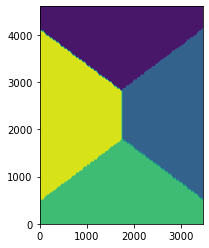

In [6]:
from scipy.spatial.distance import cdist

def associate_point_to_player(image_shape, point):
    image_rows, image_columns = image_shape
    point_row , point_column  = point
    
    player_points = [(image_rows, image_columns / 2), (image_rows / 2, image_columns), (0, image_columns / 2), (image_rows / 2, 0)]
    
    distances = cdist(player_points, [point])
    
    player = np.argmin(distances) + 1
    
    return player


n_rows, n_cols, _ = image.shape
rows_list = np.linspace(0, n_rows-1, 100)
cols_list = np.linspace(0, n_cols-1, 100)
rows_mesh, cols_mesh = np.meshgrid(rows_list, cols_list)

res = [associate_point_to_player((n_rows, n_cols), (p1, p2)) for p1, p2 in zip(rows_mesh.ravel(), cols_mesh.ravel())]
res = np.reshape(res, rows_mesh.shape)

plt.contourf(cols_mesh, rows_mesh, res)
plt.gca().set_aspect('equal')

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

In [64]:
# global widht_height_list
# width_height_list = []


class Extractor():
    
    def __init__(self, canny_thresholds = (25, 100), hough_circles_parameters = (50, 30), sigma_gaussian_blur = 5,
                 smaller_card_side_range = (400, 700), larger_card_size_range = (600, 900), nms_threshold = 0.3,
                 tolerance = 30, min_size = 2000, median_filter_size = 5):
        """
        tolerance::[float]
            Tolerance in inequality check to decide whether components are close enough.
        min_size::[int]
                Minimum size in number of pixels of component to be considered a valid object.
        """
        
        # Parameters used to extract dealer circle.
        self.hough_circles_parameters = hough_circles_parameters
        
        # Parameters used to extract cards.
        self.canny_thresholds = canny_thresholds
        self.sigma_gaussian_blur = sigma_gaussian_blur
        self.smaller_card_side_range = (min(smaller_card_side_range), max(smaller_card_side_range))
        self.larger_card_size_range  = (min(larger_card_size_range ), max(larger_card_size_range ))
        self.nms_threshold = nms_threshold
        
        # Parameters used to extract figures and suits.
        self.tolerance = tolerance
        self.min_size  = min_size
        self.median_filter_size = median_filter_size
        
        
    def __call__(self, image):
        return self._extract(image) 
        
        
    def _extract(self, image):
        dealer_circle, dealer_player = self._extract_dealer(image)
        
        cards = self._extract_cards(image, dealer_circle)
        
        figures_suits = self._extract_figures_suits(cards)
        
        return dealer_player, cards, figures_suits
        
        
        
    def _extract_dealer(self, image):
        green_mask  = get_color_pixels(image, "green")

        # Extract circle.
        circles = cv2.HoughCircles(green_mask, cv2.HOUGH_GRADIENT, dp = 1,
                                   minDist = np.inf, 
                                   param1  = self.hough_circles_parameters[0], 
                                   param2  = self.hough_circles_parameters[1])

        circles = np.uint16(np.around(circles))

        # Take the only circle detected, as we put a high minimum distance.
        column, row, radius = circles[0][0]
        
        # Show detection.
        #plt.imshow(image[row-radius:row+radius,column-radius:column+radius][:,:,::-1])
        #plt.show()
        
        # Determine which player is dealer.
        dealer_player = self._associate_point_to_player(image, (row, column))
        
        return (column, row, radius), dealer_player
        
    
    def _extract_cards(self, image, dealer_circle):
        column, row, radius = dealer_circle
        
        gradient = cv2.Canny(image, *self.canny_thresholds) 

        gradient_no_circle         = cv2.circle(gradient, (column, row), int(radius * 1.1), (0, 0, 0), cv2.FILLED)
        gradient_no_circle_blurred = cv2.GaussianBlur(gradient_no_circle, None, sigmaX = self.sigma_gaussian_blur)
        
        # Here as we don't use hierarcy returned parameter we don't need RETR_TREE and we can use RETR_LIST
        contours, _ = cv2.findContours(gradient_no_circle_blurred, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        bounding_boxes = []
        for contour in contours:
            bbox = cv2.boundingRect(contour)
            if self._bbox_can_be_card(bbox):
                bounding_boxes.append(bbox)
        
        indices = cv2.dnn.NMSBoxes(bounding_boxes, [w*h for _, _, w, h in bounding_boxes], 0, self.nms_threshold)
        bounding_boxes = [bbox for idx, bbox in enumerate(bounding_boxes) if idx in indices]
        

        cards = {}
        for bbox in bounding_boxes:
            player = self._associate_bbox_to_player(image, bbox)
            column, row, width, height = bbox
            card_image = image[row:row+height, column:column+width]
            card_image = np.rot90(card_image, 1-player)
            
            cards[player] = card_image
        
        return cards
        
    
    
    def _bbox_can_be_card(self, bbox):
        _, _, width, height = bbox
        
        # Debug only ---------
#         width_height_list.append(width)
#         width_height_list.append(height)
        # --------------------
        
        width_in_smaller_range = self.smaller_card_side_range[0] <= width <= self.smaller_card_side_range[1]
        width_in_larger_range  = self.larger_card_size_range [0] <= width <= self.larger_card_size_range [1]

        height_in_smaller_range = self.smaller_card_side_range[0] <= height <= self.smaller_card_side_range[1]
        height_in_larger_range  = self.larger_card_size_range [0] <= height <= self.larger_card_size_range [1]
        
        return (width_in_smaller_range and height_in_larger_range) or (width_in_larger_range and height_in_smaller_range)
    

    
    def _associate_point_to_player(self, image, point):       
        image_rows, image_columns = image.shape[0], image.shape[1]
        point_row , point_column  = point

        player_points = [(image_rows, image_columns / 2), (image_rows / 2, image_columns), (0, image_columns / 2), (image_rows / 2, 0)]

        distances = cdist(player_points, [point])

        player = np.argmin(distances) + 1

        return player
    
    
    def _associate_bbox_to_player(self, image, bbox):
        column, row, width, height = bbox
        center_row    = row    + height / 2
        center_column = column + width  / 2

        return self._associate_point_to_player(image, (center_row, center_column))
    
    
    def _extract_figures_suits(self, cards):
        figures_suits = {}
        
        for player, card in cards.items():
            
            # Maybe do illumination equalization? Didn't work when I tried 
            
            # Maybe instead of doing sum, do them separately and take the one with largest number of pixels to try
            # remove crappy noise
            
            mask = np.logical_or(get_color_pixels(card, "red"), get_color_pixels(card, "black")).astype(np.uint8)
            r,c = mask.shape
            num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(mask, 8)
            
            #fig, ax = plt.subplots(1, 4, figsize = (12, 5))
#             ax[0].imshow(mask)
#             ax[0].set_title(num_labels)
            
            mask = cv2.medianBlur(mask, self.median_filter_size)
            new_num_labels, new_mask = self._get_objects_from_mask(mask)

            mask = new_mask.copy() >= 1
            X = np.array(np.where(mask==1)).T
#            kmeans = GaussianMixture(n_components=3, random_state=0).fit(X)
#            kmeans = AgglomerativeClustering(n_clusters=3).fit(X)
            kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
            
#            cluster_labels = kmeans.predict(X)
            cluster1 = np.where(kmeans.labels_==0)[0]
            cluster2 = np.where(kmeans.labels_==1)[0]
            cluster3 = np.where(kmeans.labels_==2)[0]

            # kmeans-reconstruct, ugly re-code
            blank1 = np.zeros_like(mask)
            for pair in X[cluster1]:
                x,y = pair
                blank1[x,y] = 1
                
            blank2 = np.zeros_like(mask)
            for pair in X[cluster2]:
                x,y = pair
                blank2[x,y] = 1
                
            blank3 = np.zeros_like(mask)
            for pair in X[cluster3]:
                x,y = pair
                blank3[x,y] = 1
            
#             ax[1].imshow(blank1)
#             ax[2].imshow(blank2)
#             ax[3].imshow(blank3)
            
#             ax[1].imshow(new_mask, vmin = 0, vmax = new_num_labels)
#             ax[1].set_title(new_num_labels)  
            
#             plt.show()
            
            # Here maybe other filtering with bboxes? In which cases, maybe relax constraints to have neater 
            # figures, asthey will be filtered here. Important is that symbols don't merge with crap as that 
            # will increase bbox size a lot.
            
            idx_figure = np.argmin([(center[0]-r//2)**2+(center[1]-c//2)**2 
                       for center in kmeans.cluster_centers_])
            idx_suits = np.argmin([center[0]**2 + center[1]**2
                                for center in kmeans.cluster_centers_])
            
            figure_symbol = [blank1,blank2,blank3][idx_figure]
            suit_symbol   = [blank1,blank2,blank3][idx_suits][:int(r/3.5),:int(c/3.5)]
            
            
            figures_suits[player] = {"figure": figure_symbol, "suit": suit_symbol}   
            
        return figures_suits
            
    def _detect_same_object(self, component1, component2):
        """
        Function returning whether two components are sufficiently close to be classified as belonging
        to same object. 

        Args:
            component1::[dict]
                Dictionary of form {"centroid": np.array, "width": float, "height": float} containing
                information about the first connected component.
            component2::[dict]
                Dictionary of form {"centroid": np.array, "width": float, "height": float} containing
                information about the second connected component.        
        Returns:
            output::[boolean]
                True if the components are close enough to probably be part of the same object, False
                otherwise.
        """
        distance = np.linalg.norm(component1["centroid"] - component2["centroid"])
        radius_component1 = (component1["width"] + component1["height"]) / 4 
        radius_component2 = (component2["width"] + component2["height"]) / 4 

        return distance <= radius_component1 + self.tolerance or distance <= radius_component2 + self.tolerance


    def _get_objects_from_mask(self, mask):
        """
        Function returning segmentation mask of objects obtained by cleaning the color mask passed
        as parameter. 

        Args:
            mask::[np.array]
                Image mask obtained by color thresholding.
        Returns:
            objects_mask::[np.array]
                Mask of same size as input mask segmenting the objects which are large enough and
                grouped into one object if they are close enough.
        """
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

        # Merging close components that belong to same object, skipping background labeled 0.
        new_labels = {}
        for component1 in range(1, num_labels):
            parameters1 = {"centroid": np.array(centroids[component1]), "width": stats[component1, cv2.CC_STAT_WIDTH], "height": stats[component1, cv2.CC_STAT_HEIGHT]}
            for component2 in range(component1 + 1, num_labels):
                parameters2 = {"centroid": np.array(centroids[component2]), "width": stats[component2, cv2.CC_STAT_WIDTH], "height": stats[component2, cv2.CC_STAT_HEIGHT]}
                if self._detect_same_object(parameters1, parameters2):
                    new_labels[component2] = component1

        # Solves conflicts caused by values in dictionary which are also keys.
        key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]
        while key_value_conflicts:
            for conflict in key_value_conflicts:
                new_labels[conflict] = new_labels[new_labels[conflict]]
            key_value_conflicts = [key for key, value in new_labels.items() if value in new_labels.keys()]

        # Merges close components that belong to same object.
        for old_component, new_component in new_labels.items():
            labels[labels == old_component] = new_component

        # Removes too small groups (merges them with background).
        unique, counts = np.unique(labels, return_counts=True)
        for component, n_pixels in zip(unique, counts):
            if n_pixels < self.min_size:
                labels[labels == component] = 0
            else:
                continue
                print("N. pixels component: ", n_pixels)

        # -1 for the background
        return len(np.unique(labels)) -1 , labels
                
        
        # Creates mask from components not in background.
        objects_mask = labels > 0

        return len(np.unique(labels[objects_mask])), labels

In [65]:
data_loader = DataLoader()
extractor = Extractor()

image, _ = data_loader[2, 11]

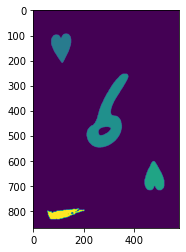

In [66]:
dealer, cards, figure_suits = extractor(image)
card = cards[2]

mask = np.logical_or(get_color_pixels(card, "red"), get_color_pixels(card, "black")).astype(np.uint8)

num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(mask, 8)
mask = cv2.medianBlur(mask, 5)
new_num_labels, new_mask = extractor._get_objects_from_mask(mask)

plt.imshow(new_mask)

Game: 1, Round: 1
N. pixels component:  399320
N. pixels component:  5129
N. pixels component:  29672
N. pixels component:  5191


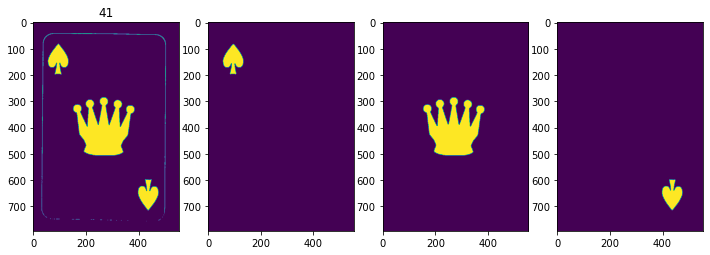

N. pixels component:  469161
N. pixels component:  5097
N. pixels component:  23117
N. pixels component:  5292


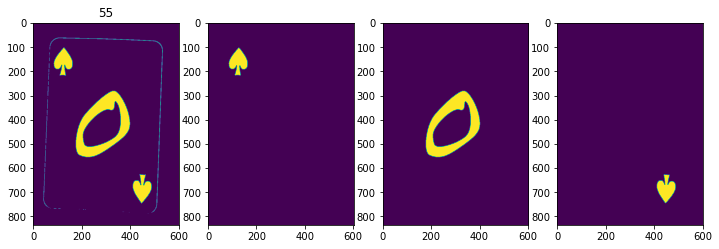

N. pixels component:  449858
N. pixels component:  6042
N. pixels component:  21548
N. pixels component:  6309


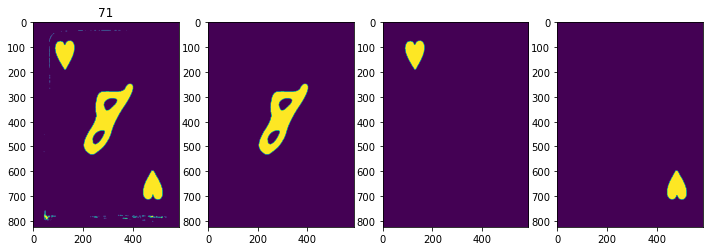

N. pixels component:  445789
N. pixels component:  5880
N. pixels component:  23588
N. pixels component:  5666


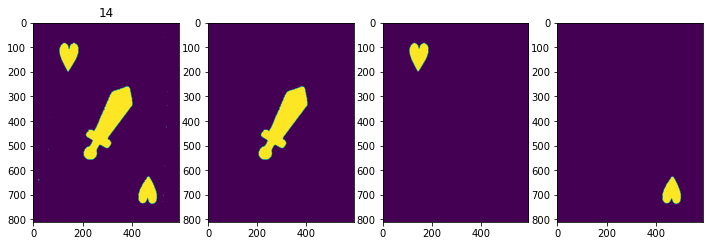

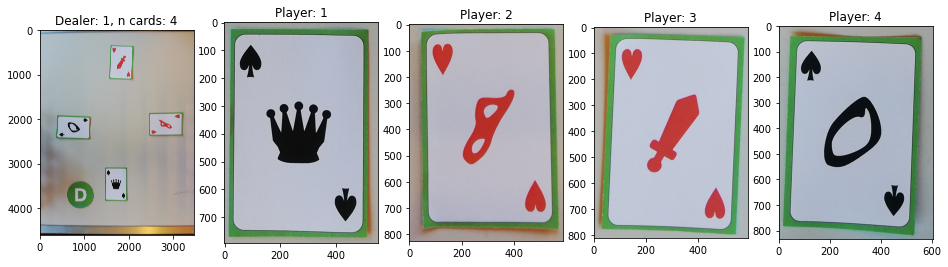

Game: 1, Round: 2
N. pixels component:  539704
N. pixels component:  5124
N. pixels component:  19427
N. pixels component:  5125


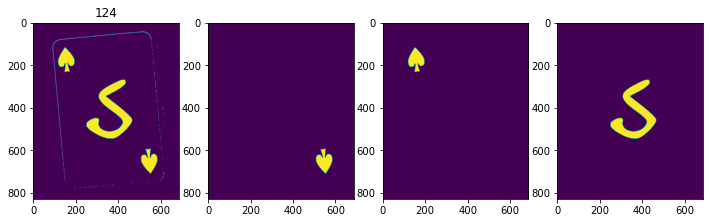

N. pixels component:  454607
N. pixels component:  3649
N. pixels component:  28060
N. pixels component:  3291


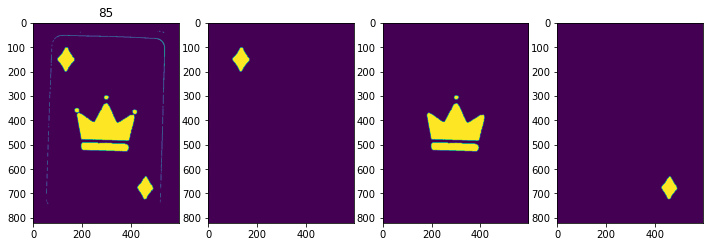

N. pixels component:  453403
N. pixels component:  5202
N. pixels component:  24156
N. pixels component:  5239


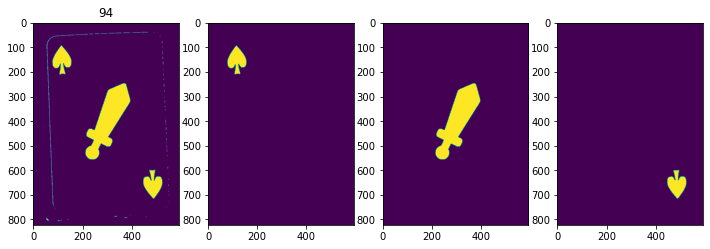

N. pixels component:  449461
N. pixels component:  4768
N. pixels component:  17166
N. pixels component:  4611


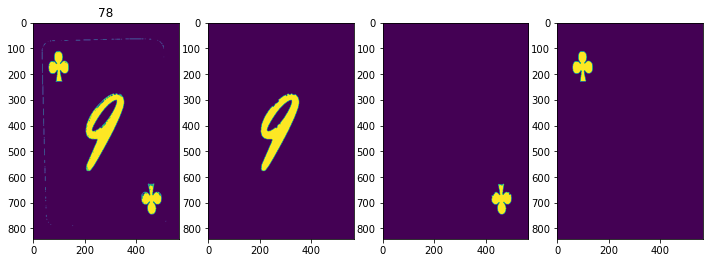

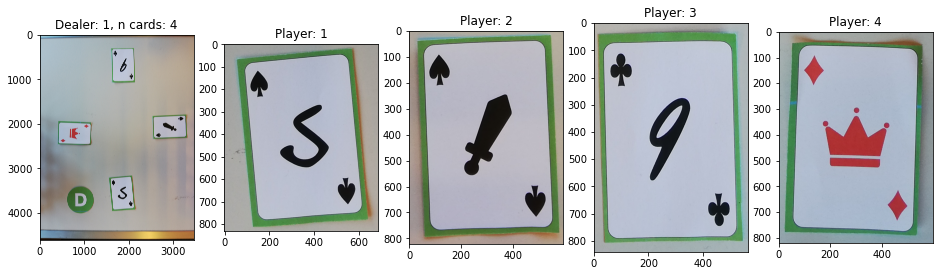

Game: 1, Round: 3
N. pixels component:  501353
N. pixels component:  3806
N. pixels component:  11495
N. pixels component:  3491


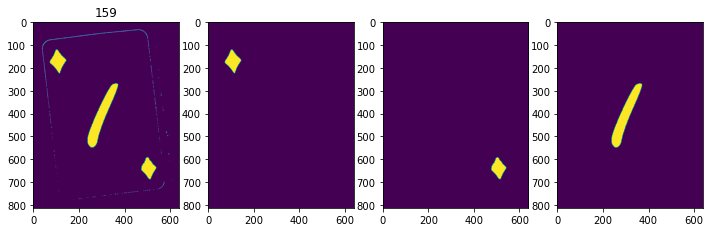

N. pixels component:  435919
N. pixels component:  3673
N. pixels component:  23933
N. pixels component:  3239


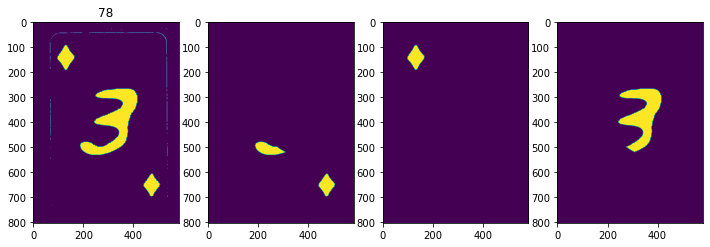

N. pixels component:  379552
N. pixels component:  6089
N. pixels component:  27143
N. pixels component:  6257


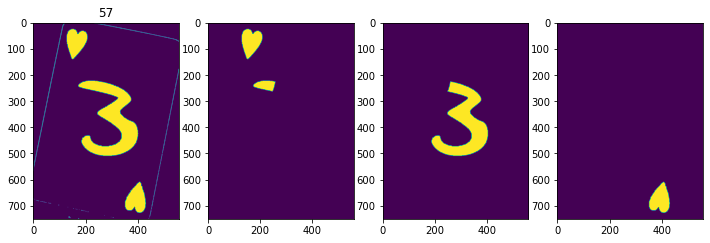

N. pixels component:  470206
N. pixels component:  4753
N. pixels component:  15046
N. pixels component:  4067


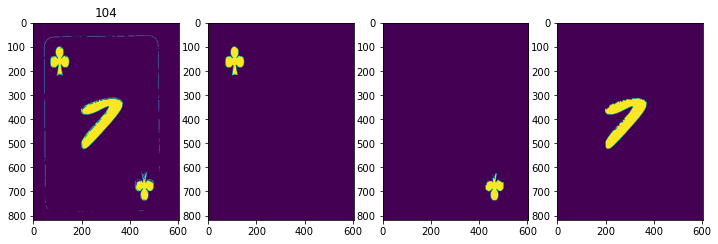

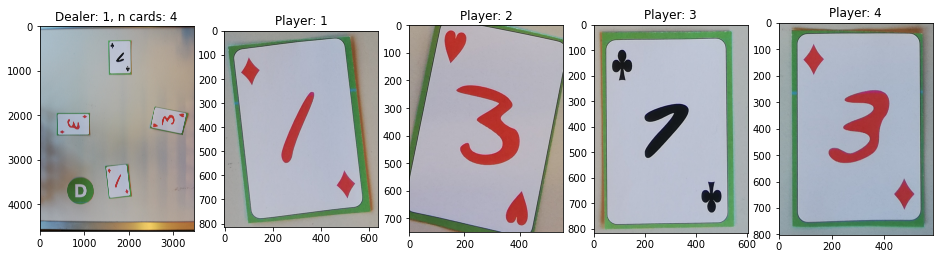

Game: 1, Round: 4
N. pixels component:  496141
N. pixels component:  5061
N. pixels component:  11135
N. pixels component:  5001


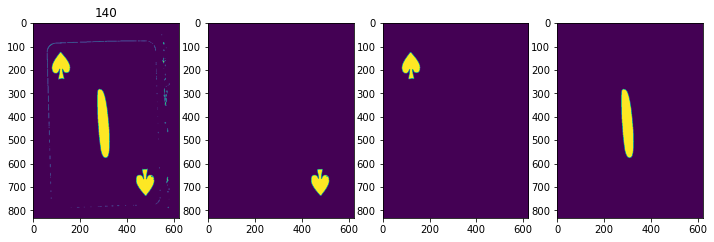

N. pixels component:  522780
N. pixels component:  4461
N. pixels component:  14984
N. pixels component:  3995


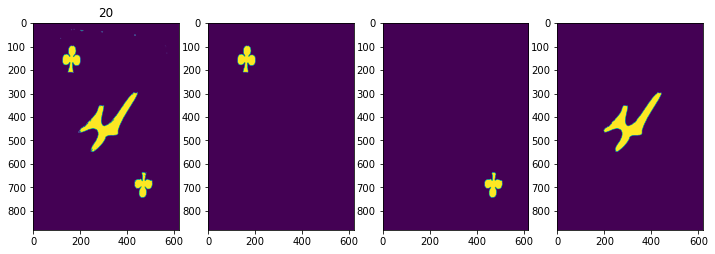

N. pixels component:  435314
N. pixels component:  3893
N. pixels component:  24141
N. pixels component:  3825


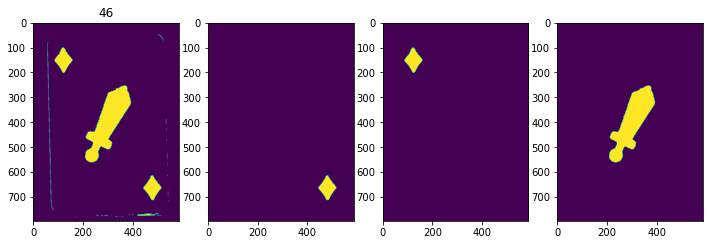

N. pixels component:  482028
N. pixels component:  4893
N. pixels component:  14095
N. pixels component:  4384


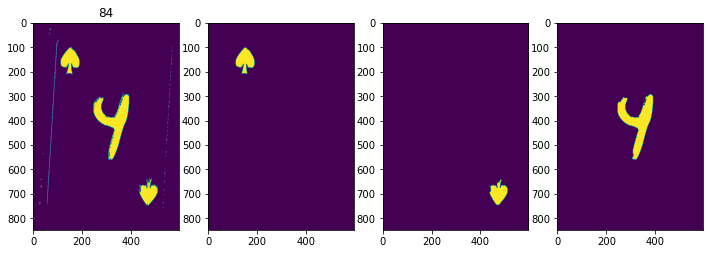

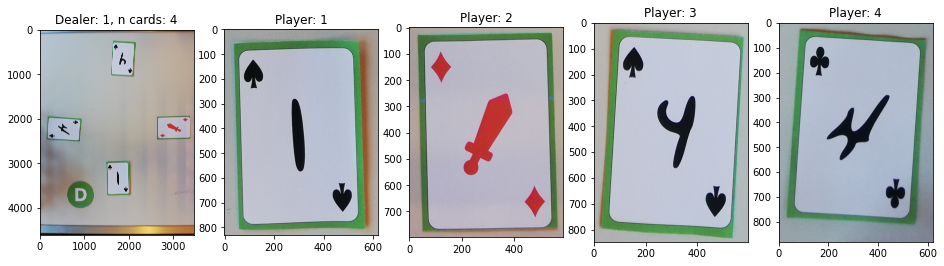

Game: 1, Round: 5
N. pixels component:  480720
N. pixels component:  3970
N. pixels component:  25493
N. pixels component:  3679


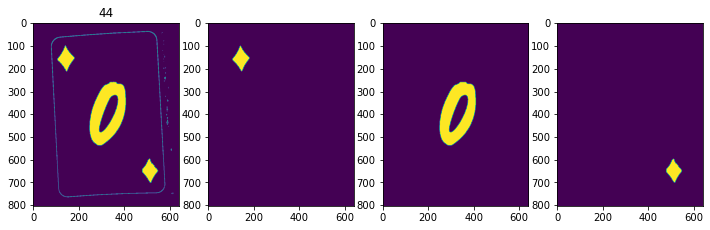

N. pixels component:  499844
N. pixels component:  5218
N. pixels component:  23890
N. pixels component:  5293
N. pixels component:  2937


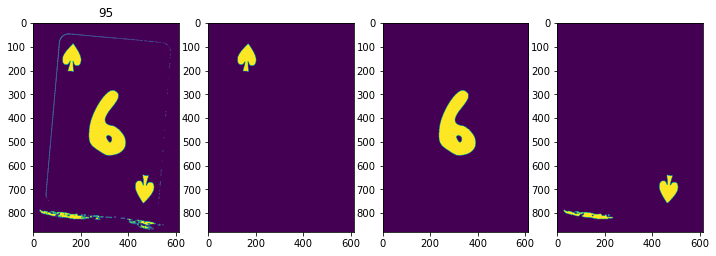

N. pixels component:  495405
N. pixels component:  4802
N. pixels component:  18011
N. pixels component:  4479


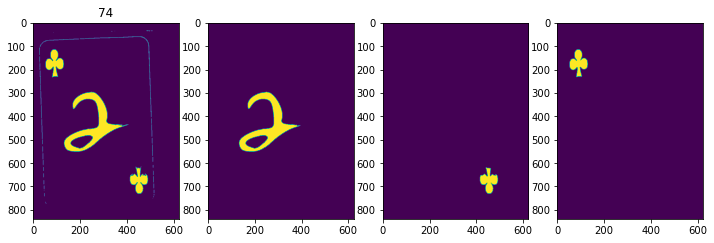

N. pixels component:  424817
N. pixels component:  4755
N. pixels component:  19984
N. pixels component:  4656


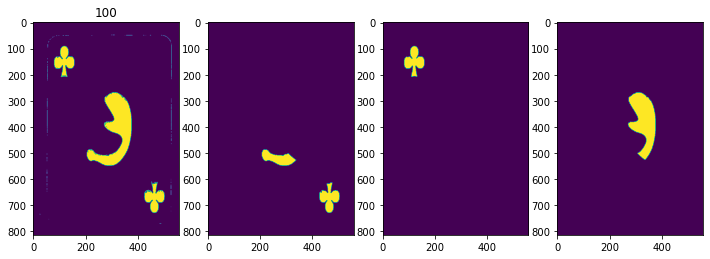

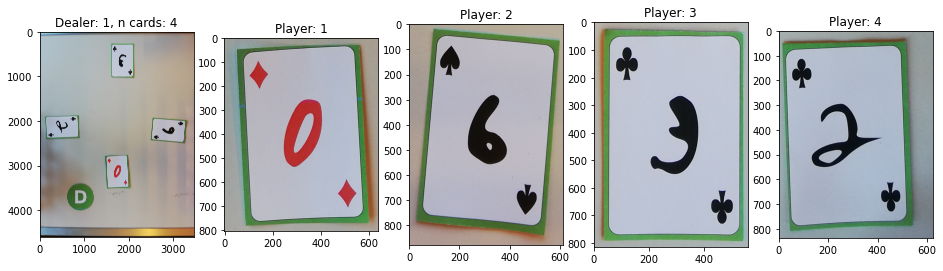

Game: 1, Round: 6
N. pixels component:  494390
N. pixels component:  4964
N. pixels component:  25240
N. pixels component:  4984


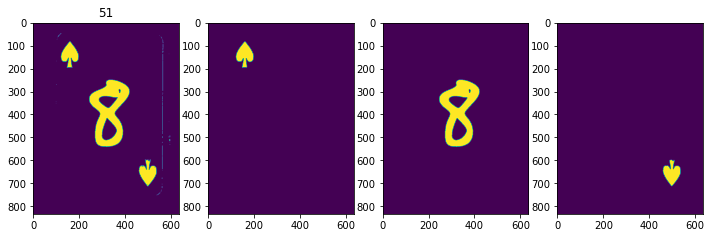

N. pixels component:  452430
N. pixels component:  3952
N. pixels component:  25443
N. pixels component:  3966
N. pixels component:  4488


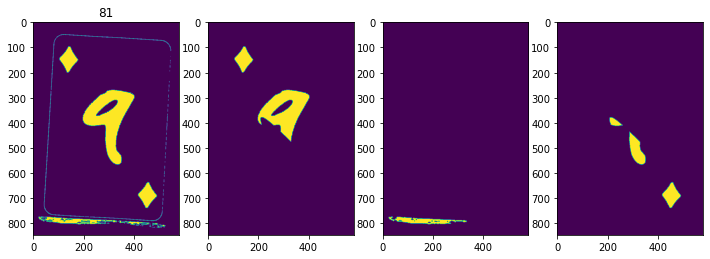

N. pixels component:  479302
N. pixels component:  4707
N. pixels component:  24661
N. pixels component:  4131


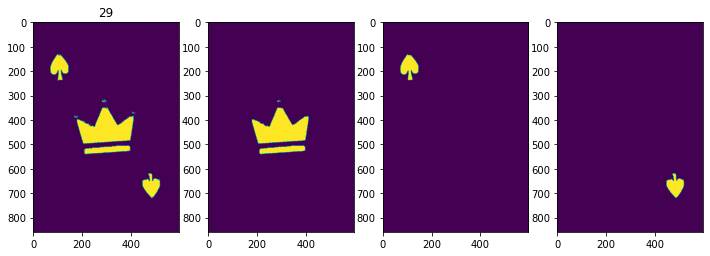

N. pixels component:  445503
N. pixels component:  5117
N. pixels component:  31274
N. pixels component:  4512


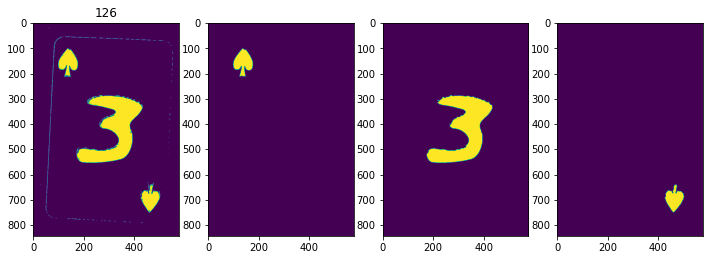

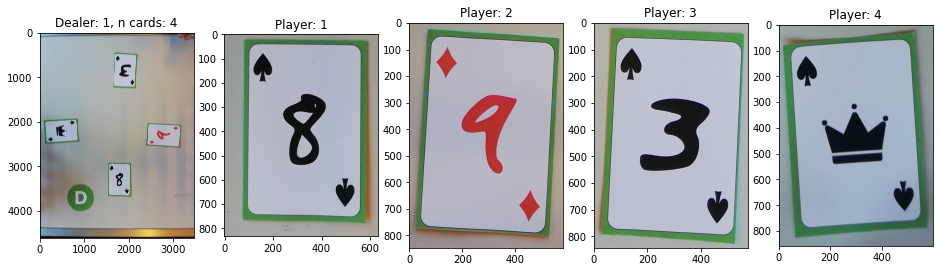

Game: 1, Round: 7
N. pixels component:  490714
N. pixels component:  3875
N. pixels component:  23078
N. pixels component:  3652


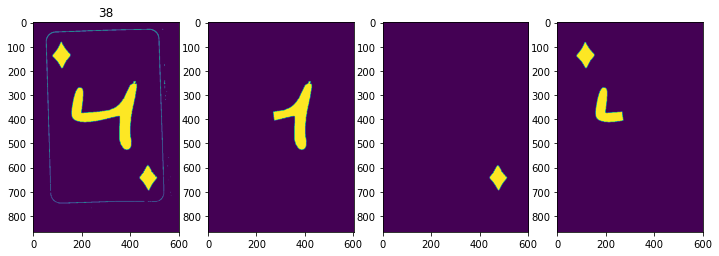

N. pixels component:  416211
N. pixels component:  6157
N. pixels component:  23172
N. pixels component:  6192


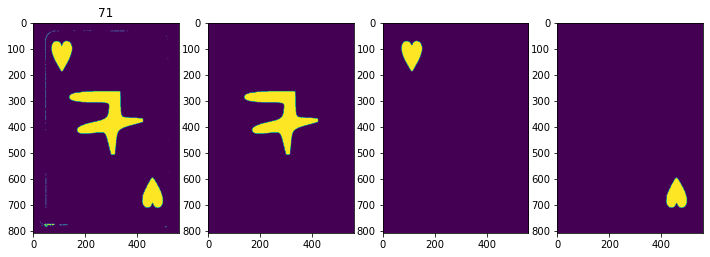

N. pixels component:  453243
N. pixels component:  5789
N. pixels component:  18226
N. pixels component:  5466


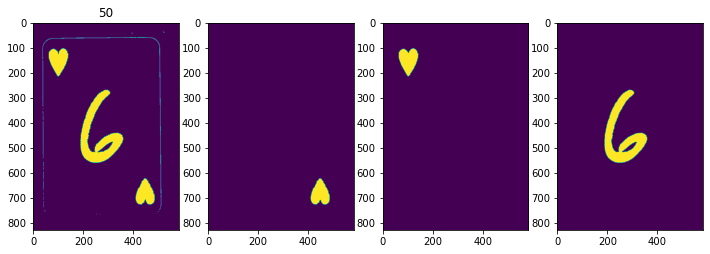

N. pixels component:  450024
N. pixels component:  4037
N. pixels component:  18517
N. pixels component:  4272


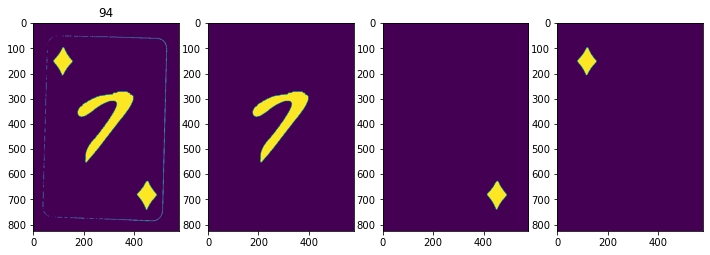

KeyboardInterrupt: 

In [26]:
for game in range(1, 7+1):
    for round_ in range(1, 13+1):
        print("Game: {}, Round: {}".format(game, round_))
        image, _ = data_loader[game, round_]
        dealer, cards = extractor(image)
        
        fig, axes = plt.subplots(1, 5, figsize = (16, 5))
        
        for player, ax in zip(sorted(cards.keys()), axes[1:]):
            ax.set_title("Player: " + str(player))
            ax.imshow(cards[player][:,:,::-1])
        
        axes[0].imshow(image[:,:,::-1])
        axes[0].set_title("Dealer: " + str(dealer) + ", n cards: " + str(len(cards)))
        plt.show()

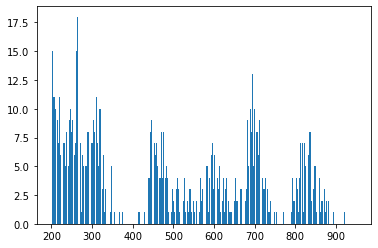

In [9]:
plt.hist([elem for elem in width_height_list if elem > 200 and elem < 1000], bins=1000);